In [2]:
!pip install -q kaggle

Download Dataset from kaggle

In [4]:
!mkdir -p ~/.kaggle
!mkdir -p data
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification
!unzip -q '*.zip' -d data # to download to a folder

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os

In [6]:
paths = pd.read_csv('data/cards.csv')
paths.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [51]:
paths['class index'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

In [8]:
train = paths[paths["filepaths"].str.startswith("train") == True]
train = train[~train["filepaths"].str.startswith("train/ace of clubs/output")]
val = paths[paths["filepaths"].str.startswith("valid") == True]
test = paths[paths["filepaths"].str.startswith("test") == True]

In [44]:
train_path = train["filepaths"].values
train_label = train['class index'].values

val_path = val["filepaths"].values
val_label = val['class index'].values

test_path = test["filepaths"].values
test_label = test['class index'].values

In [45]:
train_label[:5]

array([0, 0, 0, 0, 0])

In [46]:
class PlayingCardsDataset(Dataset):
  #                   data,  train_path, train_label
  def __init__(self, img_dir, img_paths, labels, transform = None, target_transform = None):
    self.img_dir = img_dir
    # print(f"self.img_dir: {self.img_dir}")
    self.image_paths = img_paths
    # print(f"self.image_paths: {self.image_paths[0]}")
    self.transform = transform
    self.target_transform = target_transform
    self.labels = labels
    # print("Value of 0: ", os.path.join(self.img_dir, self.image_paths[0]))
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.image_paths[idx])
    # print(img_path)
    image = read_image(img_path)
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

In [48]:
data = "/content/data/"

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_data = PlayingCardsDataset(data, train_path, train_label, transform)
val_data = PlayingCardsDataset(data, val_path, val_label, transform)
test_data = PlayingCardsDataset(data, test_path, test_label, transform)
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False)

In [49]:
len(train_data)

7624

In [63]:
image, label = train_data[453]
print(image.shape)
print(label)

torch.Size([3, 128, 128])
3


In [51]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


In [52]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes):
    super(SimpleCNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1), # 32, 16, 128,128
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2), # 32, 16x 64 x64
        nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1), # 32,32,64,64
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2), # 32,32, 32,32
        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1), # 32,64,32,32
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2), # 32,64,16
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 16 * 16, 512),
        nn.ReLU(inplace = True),
        nn.Dropout(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x


In [53]:
model = SimpleCNN(num_classes=53)

In [54]:
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=53, bias=True)
  )
)


In [55]:
out = model(train_features)

In [56]:
out.shape

torch.Size([32, 53])

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [70]:
num_epochs = 30
train_loss, val_loss = [], []
model = SimpleCNN(num_classes=53)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model.to(device)
for epoch in range(num_epochs):
  # training phase

  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    # print(images)
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)
  epoch_loss = running_loss / len(train_loader.dataset)
  train_loss.append(epoch_loss)


  # Validation Phase
  model.eval()
  with torch.no_grad():
    running_loss = 0.0
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)
    val_epoch_loss = running_loss / len(val_loader.dataset)
    val_loss.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")


Epoch 1/30, Train Loss: 3.7545, Val Loss: 3.0138
Epoch 2/30, Train Loss: 3.0118, Val Loss: 2.3329
Epoch 3/30, Train Loss: 2.6513, Val Loss: 1.9253
Epoch 4/30, Train Loss: 2.4047, Val Loss: 1.7470
Epoch 5/30, Train Loss: 2.2347, Val Loss: 1.6115
Epoch 6/30, Train Loss: 2.0750, Val Loss: 1.4740
Epoch 7/30, Train Loss: 1.9640, Val Loss: 1.3752
Epoch 8/30, Train Loss: 1.8539, Val Loss: 1.2762
Epoch 9/30, Train Loss: 1.7379, Val Loss: 1.2210
Epoch 10/30, Train Loss: 1.6670, Val Loss: 1.1815
Epoch 11/30, Train Loss: 1.5577, Val Loss: 1.1289
Epoch 12/30, Train Loss: 1.4935, Val Loss: 1.0867
Epoch 13/30, Train Loss: 1.4016, Val Loss: 1.0534
Epoch 14/30, Train Loss: 1.3277, Val Loss: 1.0265
Epoch 15/30, Train Loss: 1.2587, Val Loss: 0.9914
Epoch 16/30, Train Loss: 1.1918, Val Loss: 0.9737
Epoch 17/30, Train Loss: 1.1283, Val Loss: 0.9265
Epoch 18/30, Train Loss: 1.0661, Val Loss: 0.9060
Epoch 19/30, Train Loss: 1.0157, Val Loss: 0.9231
Epoch 20/30, Train Loss: 0.9630, Val Loss: 0.9248
Epoch 21/

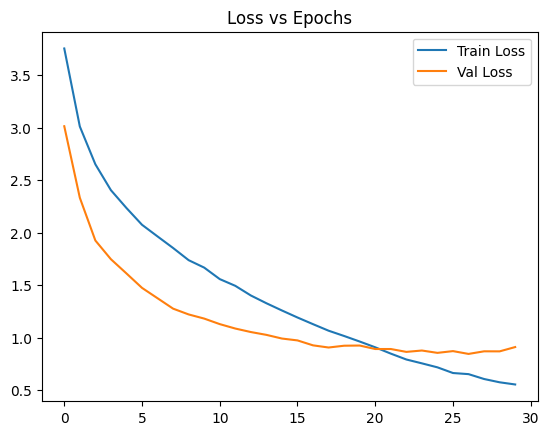

In [71]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = "Train Loss")
plt.plot(val_loss, label = "Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.show()